# PAC Learning — Lecture 5: Visual Guide

This notebook walks through every concept in **Lecture 5 (PAC Learning)** with 2D halfspace
visualizations that match the slide diagrams.

> Each section header notes the **slide numbers** it covers.  
> 🗣️ **Plain English** blocks explain every piece of math in everyday language.

---

**Running Example** (used throughout):
- Data: $(x_1, x_2) \sim \mathrm{Uniform}([0,1]^2)$
- True label: $y = \mathbf{1}[x_1 + x_2 \geq 1]$
- Hypothesis class $\mathcal{H}$: 21 halfspace classifiers — lines through the center $(0.5, 0.5)$ at angles $\theta \in \{-45°, -36°, \ldots, 45°, \ldots, 126°, 135°\}$
- True boundary ($x_1 + x_2 = 1$) corresponds to $\theta^\star = 45°$, so **realizability** holds.

### Breaking Down the Running Example

---

#### Part by Part

**$(x_1, x_2) \sim \mathrm{Uniform}([0,1]^2)$** — how we generate data

Each data point is a random location in the unit square. Both coordinates are drawn uniformly between 0 and 1, independently.

**$y = \mathbf{1}[x_1 + x_2 \geq 1]$** — the true labeling rule

The label is 1 (blue) if the point is above-right of the diagonal $x_1 + x_2 = 1$, and 0 (red) if below-left. This is the ground truth we're trying to learn.

**$\mathcal{H}$** — the hypothesis class (our menu of candidate models)

A set of 21 straight lines through the center $(0.5, 0.5)$, each at a different angle. Each line defines a classifier: "predict 1 on one side, 0 on the other."

**$\theta^\star = 45°$** — the true hypothesis

The line at 45° exactly matches the true diagonal $x_1 + x_2 = 1$. Because this line is in $\mathcal{H}$, we say **realizability** holds.

---

#### Why This Setup?

We have a finite set of 21 models. One of them is perfect. The learner doesn't know which one — it only sees training data. **PAC learning asks: how many training points guarantee that the learner picks a model that's close to perfect?**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math

plt.rcParams['figure.dpi'] = 130
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 12
np.random.seed(42)

# === 2D Running Example ===
ANGLES_DEG = np.arange(-45, 136, 9)           # 21 angles
ANGLES = np.deg2rad(ANGLES_DEG.astype(float))
TRUE_ANGLE = np.deg2rad(45)
TRUE_IDX = int(np.argmin(np.abs(ANGLES - TRUE_ANGLE)))
H_SIZE = len(ANGLES)                           # |H| = 21

# Compute true errors on a fine grid
_g = np.linspace(0, 1, 500)
_G1, _G2 = np.meshgrid(_g, _g)
_ty = (_G1 + _G2 >= 1).astype(int)
TRUE_ERRORS = np.array([
    np.mean((np.cos(th)*(_G1-0.5) + np.sin(th)*(_G2-0.5) >= 0).astype(int) != _ty)
    for th in ANGLES])
del _g, _G1, _G2, _ty

# EPSILON: choose so exactly 5 hypotheses are "good"
_se = np.sort(TRUE_ERRORS)
EPSILON = round((_se[4] + _se[5]) / 2, 3)

# --- Helper: boundary segment clipped to [0,1]^2 ---
def _boundary_seg(theta):
    c, s = np.cos(theta), np.sin(theta)
    ts = []
    if abs(s) > 1e-10:
        for t in [0.5/s, -0.5/s]:
            p = (0.5 - s*t, 0.5 + c*t)
            if -1e-9 <= p[0] <= 1+1e-9 and -1e-9 <= p[1] <= 1+1e-9:
                ts.append(t)
    if abs(c) > 1e-10:
        for t in [-0.5/c, 0.5/c]:
            p = (0.5 - s*t, 0.5 + c*t)
            if -1e-9 <= p[0] <= 1+1e-9 and -1e-9 <= p[1] <= 1+1e-9:
                ts.append(t)
    ut = [ts[0]]
    for t in ts[1:]:
        if all(abs(t-u)>1e-8 for u in ut): ut.append(t)
    t0, t1 = min(ut), max(ut)
    return [(np.clip(0.5-s*t0,0,1), np.clip(0.5+c*t0,0,1)),
            (np.clip(0.5-s*t1,0,1), np.clip(0.5+c*t1,0,1))]

def draw_boundary(ax, theta, **kw):
    p1, p2 = _boundary_seg(theta)
    ax.plot([p1[0],p2[0]], [p1[1],p2[1]], **kw)

# --- Helper: consistency mask (vectorized) ---
def get_consistent_mask(x, y):
    d = (np.cos(ANGLES)[:,None]*(x[:,0]-0.5)[None,:] +
         np.sin(ANGLES)[:,None]*(x[:,1]-0.5)[None,:])
    return np.all((d >= 0).astype(int) == y[None,:], axis=1)

n_good = int(np.sum(TRUE_ERRORS <= EPSILON + 1e-9))
print(f"|H| = {H_SIZE} halfspace classifiers through (0.5, 0.5)")
print(f"Angles: {list(ANGLES_DEG)}deg")
print(f"True errors: {[f'{e:.3f}' for e in TRUE_ERRORS]}")
print(f"EPSILON = {EPSILON}")
print(f"Good hypotheses (error <= eps): {n_good}")
print(f"Bad hypotheses  (error >  eps): {H_SIZE - n_good}")

|H| = 21 halfspace classifiers through (0.5, 0.5)
Angles: [-45, -36, -27, -18, -9, 0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135]deg
True errors: ['0.499', '0.432', '0.377', '0.331', '0.290', '0.250', '0.210', '0.169', '0.123', '0.068', '0.001', '0.068', '0.123', '0.169', '0.210', '0.250', '0.290', '0.331', '0.377', '0.432', '0.499']
EPSILON = 0.146
Good hypotheses (error <= eps): 5
Bad hypotheses  (error >  eps): 16


---
## Slides 4–6 — Motivation: What Does "Correct" Mean?

**Slide 4**: A learning algorithm might get $L_S(h_S) = 0$ (zero training error) but still have
$L_{\mathcal{D}}(h_S) > 0$ (nonzero true error).

**Slide 5 — Approximately Correct**: We want $L_{\mathcal{D}}(h_S) \leq \epsilon$.

**Slide 6 — Probably Approximately Correct**: Since $S$ is random, we settle for:
$$\Pr_{S \sim \mathcal{D}^m}[L_{\mathcal{D}}(h_S) \leq \epsilon] \geq 1 - \delta$$

### Breaking Down the Key Quantities

---

**$L_S(h_S) = 0$** — training error is zero

$L_S$ counts the fraction of *training* examples the model gets wrong. Zero means it classified every training point correctly. But this says nothing about new, unseen data.

**$L_{\mathcal{D}}(h_S)$** — true error (a.k.a. generalization error)

$L_{\mathcal{D}}$ measures how often the model makes mistakes over the *entire* population — all possible data points, not just the ones in training. This is what we actually care about.

**$L_{\mathcal{D}}(h_S) > 0$** — the model isn't perfect

Even though training error is zero, the model can still be wrong on data it hasn't seen.

---

### Breaking Down the PAC Definition

$$\Pr_{S \sim \mathcal{D}^m}\!\left[L_{\mathcal{D}}(h_S) \leq \epsilon\right] \geq 1 - \delta$$

---

#### Part by Part

**$S \sim \mathcal{D}^m$** — draw a random training set

We draw $m$ examples independently from distribution $\mathcal{D}$. This randomness is the source of all uncertainty.

**$h_S$** — the model our algorithm outputs after seeing $S$

Different training sets → potentially different models.

**$L_{\mathcal{D}}(h_S) \leq \epsilon$** — the "approximately correct" part

The model's true error is at most $\epsilon$. If $\epsilon = 0.05$, we tolerate up to 5% mistakes on new data.

**$\Pr[\ldots] \geq 1 - \delta$** — the "probably" part

This good outcome happens with probability at least $1 - \delta$. If $\delta = 0.05$, then 95% of all possible training sets lead to a good model.

---

#### The Whole Thing

> "With probability at least $1 - \delta$ over the random draw of training data, the learned model has true error at most $\epsilon$."

#### Why Two Parameters?

- **$\epsilon$** controls *accuracy*: how close to perfect does the model need to be?
- **$\delta$** controls *confidence*: how sure do we need to be that it works?

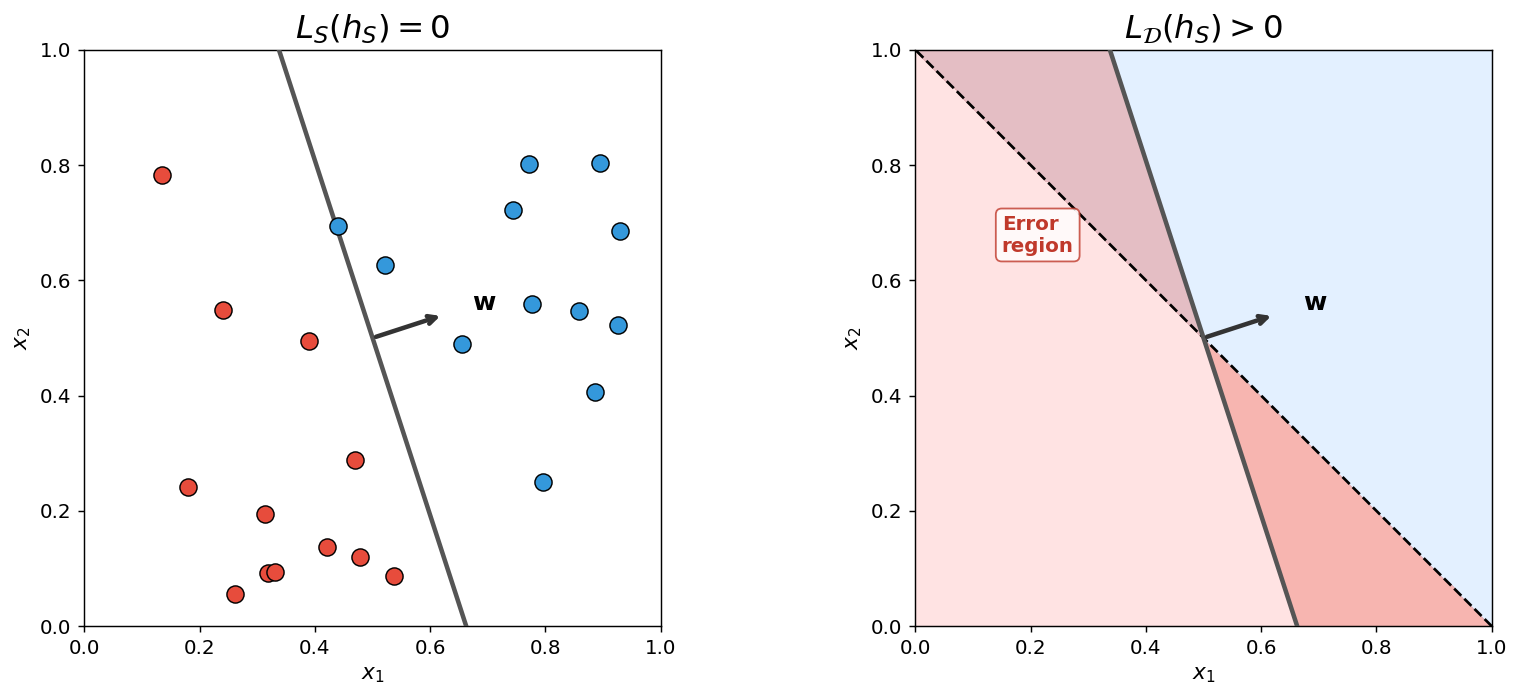

In [2]:
# Motivation: L_S = 0 does NOT mean L_D = 0 (matching the slide diagram)

fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
theta_demo = np.deg2rad(18)   # a "wrong" hypothesis (27deg from true)

# Generate training data consistent with this wrong hypothesis
np.random.seed(99)
_x = np.random.uniform(0.05, 0.95, (500, 2))
_y = (_x[:,0] + _x[:,1] >= 1).astype(int)
_d = np.cos(theta_demo)*(_x[:,0]-0.5) + np.sin(theta_demo)*(_x[:,1]-0.5)
_ok = ((_d >= 0).astype(int) == _y)
_x, _y = _x[_ok], _y[_ok]
_i0, _i1 = np.where(_y==0)[0][:12], np.where(_y==1)[0][:12]
x_demo = np.vstack([_x[_i0], _x[_i1]])
y_demo = np.concatenate([_y[_i0], _y[_i1]])

# --- LEFT: training data, perfectly separated ---
ax = axes[0]
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal')
for xi, yi in zip(x_demo, y_demo):
    c = '#3498db' if yi == 1 else '#e74c3c'
    ax.scatter(xi[0], xi[1], c=c, s=90, edgecolor='black', linewidth=0.8, zorder=5)
draw_boundary(ax, theta_demo, color='#555', linewidth=2.5, zorder=3)
# weight vector arrow
al = 0.13
ax.annotate('', xy=(0.5+al*np.cos(theta_demo), 0.5+al*np.sin(theta_demo)),
            xytext=(0.5, 0.5),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#333'))
ax.text(0.5+0.16*np.cos(theta_demo)+0.02, 0.5+0.16*np.sin(theta_demo),
        r'$\mathbf{w}$', fontsize=14, fontweight='bold')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title(r'$L_S(h_S) = 0$', fontsize=18)

# --- RIGHT: true distribution with error region ---
ax = axes[1]
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal')
grid = np.linspace(0, 1, 300)
G1, G2 = np.meshgrid(grid, grid)
true_lab = (G1 + G2 >= 1).astype(int)
hyp_lab = (np.cos(theta_demo)*(G1-0.5) + np.sin(theta_demo)*(G2-0.5) >= 0).astype(int)
err_region = (true_lab != hyp_lab).astype(float)

ax.contourf(G1, G2, true_lab, levels=[-0.5,0.5,1.5],
            colors=['#ffcccc','#cce5ff'], alpha=0.55)
ax.contourf(G1, G2, err_region, levels=[0.5,1.5],
            colors=['#e74c3c'], alpha=0.30)
draw_boundary(ax, theta_demo, color='#555', linewidth=2.5, zorder=3)
draw_boundary(ax, TRUE_ANGLE, color='black', linewidth=1.5, linestyle='--', zorder=2)
ax.annotate('', xy=(0.5+al*np.cos(theta_demo), 0.5+al*np.sin(theta_demo)),
            xytext=(0.5, 0.5),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#333'))
ax.text(0.5+0.16*np.cos(theta_demo)+0.02, 0.5+0.16*np.sin(theta_demo),
        r'$\mathbf{w}$', fontsize=14, fontweight='bold')
ax.text(0.15, 0.65, 'Error\nregion', fontsize=11, color='#c0392b', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#c0392b', alpha=0.8))
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title(r'$L_{\mathcal{D}}(h_S) > 0$', fontsize=18)

plt.tight_layout()
plt.show()

---
## Slides 7–10 — Goal & Analysis Assumptions

**Slide 7 — Goal**: Bound $\mathcal{D}^m(\{S|_x : L_{\mathcal{D}}(h_S) > \epsilon\})$.

**Slides 8–10 — Assumptions**:

| # | Assumption | Meaning |
|---|-----------|---------|
| 1 | **i.i.d. data** | Training examples drawn independently from $\mathcal{D}$ |
| 2 | **Finite hypothesis class** | $|\mathcal{H}| < \infty$ |
| 3 | **Realizability** | $\exists\, h^\star \in \mathcal{H}$ with $L_{\mathcal{D}}(h^\star) = 0$ |
| 4 | **0-1 loss** | $\ell(h(x), y) = \mathbf{1}[h(x) \neq y]$ |

We make **no assumptions** about $\mathcal{D}$ → "distribution-free" learning.

### Breaking Down the Goal

$$\mathcal{D}^m(\{S|_x : L_{\mathcal{D}}(h_S) > \epsilon\})$$

---

#### Part by Part

**$\mathcal{D}^m$** — probability measure over datasets

We draw $m$ i.i.d. samples from distribution $\mathcal{D}$. This gives us a random training set.

**$S|_x = (x_1, x_2, \ldots, x_m)$** — the inputs of our training set

Just the features, not the labels. (Labels are determined by the true function.)

**$h_S$** — the hypothesis our algorithm outputs after training on $S$

Different training sets → potentially different learned models.

**$L_{\mathcal{D}}(h_S)$** — true error of $h_S$

How often $h_S$ makes mistakes on the *entire* population (not just training data).

**$L_{\mathcal{D}}(h_S) > \epsilon$** — "bad" outcome

Our learned model has error greater than our tolerance $\epsilon$.

**$\{S|_x : \ldots\}$** — set of all training sets where this bad thing happens

"All the unlucky datasets that lead us to learn something bad."

---

#### The Whole Thing

> "What's the probability that a random training set of size $m$ leads us to learn a hypothesis with true error greater than $\epsilon$?"

#### Why We Care

We want this probability to be small. PAC learning asks: **how big must $m$ be** to make this probability $\leq \delta$?

---

### Breaking Down Each Assumption

**i.i.d.** — each example is drawn independently from the same distribution

Like pulling marbles from a bag with replacement: each draw is fresh, the bag never changes. This is what lets us multiply probabilities later in the proof.

**$|\mathcal{H}| < \infty$** — finite hypothesis class

We have a *finite* menu of candidate models. The proof adds up one term per model, so the sum must be finite. (In our example, $|\mathcal{H}| = 21$.)

**$\exists\, h^\star \in \mathcal{H}$ with $L_{\mathcal{D}}(h^\star) = 0$** — realizability

The perfect model exists on our menu. It gets zero true error. Without this, zero training error might not even be achievable.

**$\ell(h(x), y) = \mathbf{1}[h(x) \neq y]$** — 0-1 loss

Right = 0, wrong = 1. No partial credit. The "$\mathbf{1}[\cdot]$" is an indicator function: it outputs 1 when the condition inside is true, 0 otherwise.

**Distribution-free** — no assumptions on $\mathcal{D}$

The bound works for *any* data distribution. We don't assume Gaussian, uniform, or anything else. This is powerful but also makes bounds conservative.

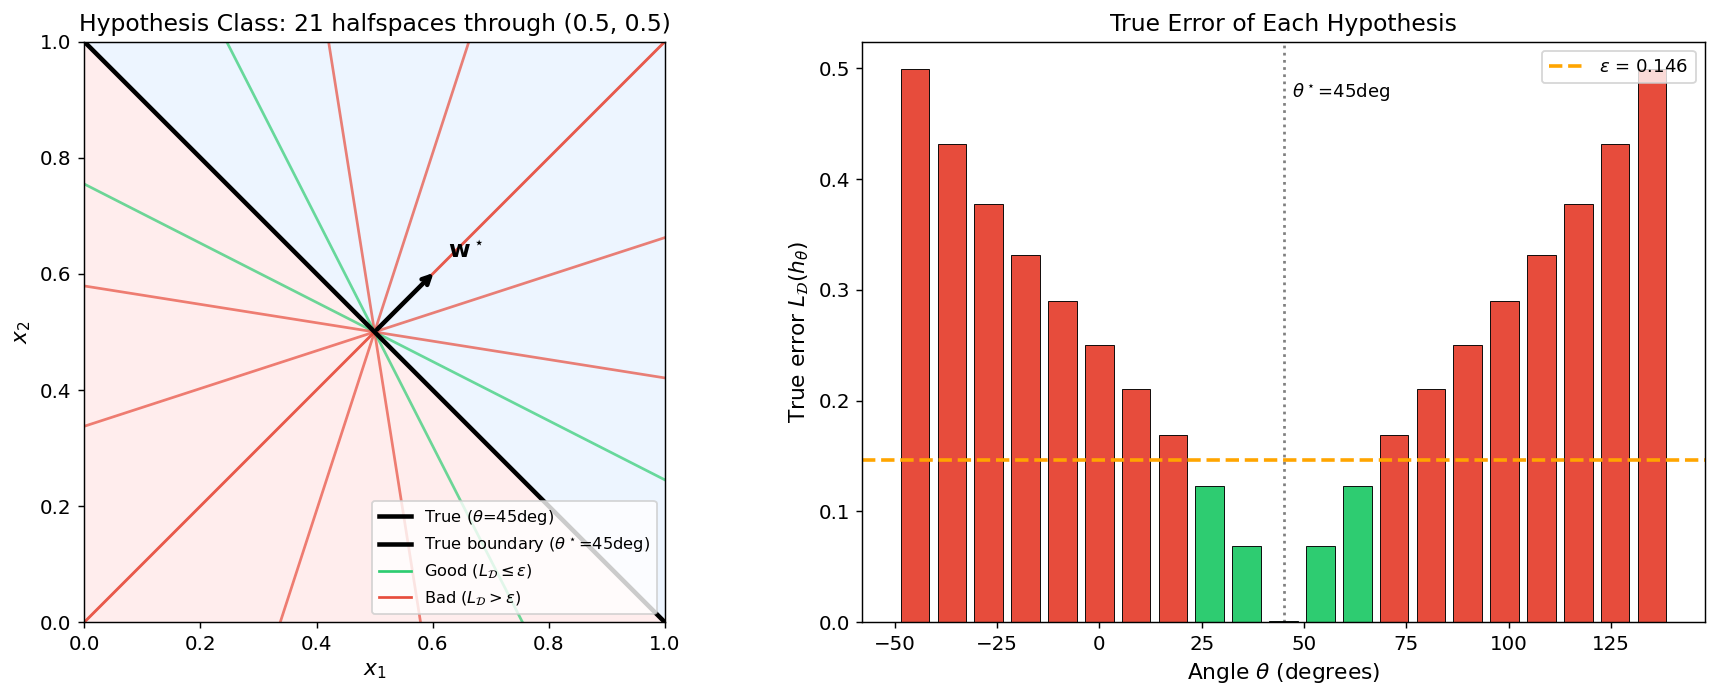

Realizability: h* at theta=45deg has true error 0.000792
|H| = 21,  |H_B| = 16


In [3]:
# Visualize: the 2D hypothesis class and true errors

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# --- LEFT: decision boundaries on [0,1]^2 ---
ax = axes[0]
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal')
# True class regions
grid = np.linspace(0, 1, 300)
G1, G2 = np.meshgrid(grid, grid)
ax.contourf(G1, G2, (G1+G2>=1).astype(int), levels=[-0.5,0.5,1.5],
            colors=['#ffcccc','#cce5ff'], alpha=0.35)

# Draw a subset of boundaries
show_idx = [0, 3, 6, 8, 10, 12, 14, 17, 20]  # representative angles
for idx in show_idx:
    err = TRUE_ERRORS[idx]
    if idx == TRUE_IDX:
        draw_boundary(ax, ANGLES[idx], color='black', linewidth=2.5,
                      label=r'True ($\theta$=45deg)', zorder=4)
    else:
        c = '#2ecc71' if err <= EPSILON+1e-9 else '#e74c3c'
        lw = 1.5
        draw_boundary(ax, ANGLES[idx], color=c, linewidth=lw, alpha=0.7)

# Weight vector for true hypothesis
al = 0.15
ax.annotate('', xy=(0.5+al*np.cos(TRUE_ANGLE), 0.5+al*np.sin(TRUE_ANGLE)),
            xytext=(0.5, 0.5),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
ax.text(0.5+0.18*np.cos(TRUE_ANGLE), 0.5+0.18*np.sin(TRUE_ANGLE),
        r'$\mathbf{w}^\star$', fontsize=13, fontweight='bold')
# legend proxies
ax.plot([], [], color='black', linewidth=2.5, label=r'True boundary ($\theta^\star$=45deg)')
ax.plot([], [], color='#2ecc71', linewidth=1.5, label=r'Good ($L_\mathcal{D} \leq \epsilon$)')
ax.plot([], [], color='#e74c3c', linewidth=1.5, label=r'Bad ($L_\mathcal{D} > \epsilon$)')
ax.legend(fontsize=9, loc='lower right')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title(f'Hypothesis Class: {H_SIZE} halfspaces through (0.5, 0.5)')

# --- RIGHT: true error bar chart ---
ax = axes[1]
colors = ['#2ecc71' if e <= EPSILON+1e-9 else '#e74c3c' for e in TRUE_ERRORS]
ax.bar(ANGLES_DEG, TRUE_ERRORS, width=7, color=colors, edgecolor='black', linewidth=0.5)
ax.axhline(y=EPSILON, color='orange', linewidth=2, linestyle='--',
           label=f'$\\epsilon$ = {EPSILON}')
ax.axvline(x=45, color='black', linewidth=1.5, linestyle=':', alpha=0.5)
ax.text(47, max(TRUE_ERRORS)*0.95, r'$\theta^\star$=45deg', fontsize=10, color='black')
ax.set_xlabel(r'Angle $\theta$ (degrees)')
ax.set_ylabel(r'True error $L_{\mathcal{D}}(h_\theta)$')
ax.set_title('True Error of Each Hypothesis')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"Realizability: h* at theta=45deg has true error {TRUE_ERRORS[TRUE_IDX]:.6f}")
print(f"|H| = {H_SIZE},  |H_B| = {int(np.sum(TRUE_ERRORS > EPSILON + 1e-9))}")

---
## Slides 11–15 — Bad Hypotheses & Misleading Samples

**Slide 11**: $\mathcal{H}_B = \{h \in \mathcal{H} : L_{\mathcal{D}}(h) > \epsilon\}$

**Slides 12–15**: A *misleading sample* has all training points far from the true boundary,
so many different decision boundaries (including bad ones) correctly classify everything.

$$M = \bigcup_{h \in \mathcal{H}_B} \{S|_x : L_S(h) = 0\}$$

### Breaking Down "Bad Hypotheses"

$$\mathcal{H}_B = \{h \in \mathcal{H} : L_{\mathcal{D}}(h) > \epsilon\}$$

---

#### Part by Part

**$h \in \mathcal{H}$** — a hypothesis from our class

One of the 21 candidate lines.

**$L_{\mathcal{D}}(h) > \epsilon$** — its true error exceeds our tolerance

This line misclassifies more than $\epsilon$ fraction of the population. It's "too wrong" for us.

**$\mathcal{H}_B$** — the set of all such "bad" hypotheses

In our example: 16 out of 21 lines are bad (their angles are too far from the true 45°).

---

#### The Whole Thing

> "$\mathcal{H}_B$ is the collection of every model on our menu whose real-world error is too high."

---

### Breaking Down "Misleading Samples"

$$M = \bigcup_{h \in \mathcal{H}_B} \{S|_x : L_S(h) = 0\}$$

---

#### Part by Part

**$L_S(h) = 0$** — bad hypothesis $h$ gets zero training error

Even though $h$ is bad (high true error), it happens to classify all training points correctly. The training data failed to expose it.

**$\{S|_x : L_S(h) = 0\}$** — all training sets that fail to catch this *specific* bad $h$

For each bad hypothesis, there's a collection of "unlucky" training sets where that hypothesis looks perfect.

**$\bigcup_{h \in \mathcal{H}_B}$** — take the union over all bad hypotheses

A sample is misleading if *any* bad hypothesis survives — not just one particular one.

---

#### The Whole Thing

> "$M$ is the set of all training sets where at least one bad hypothesis gets zero training error and could be chosen by ERM."

#### Why This Matters

If $S \notin M$, every surviving hypothesis is good → ERM can't go wrong. So: $\Pr[\text{ERM fails}] \leq \Pr[S \in M]$.

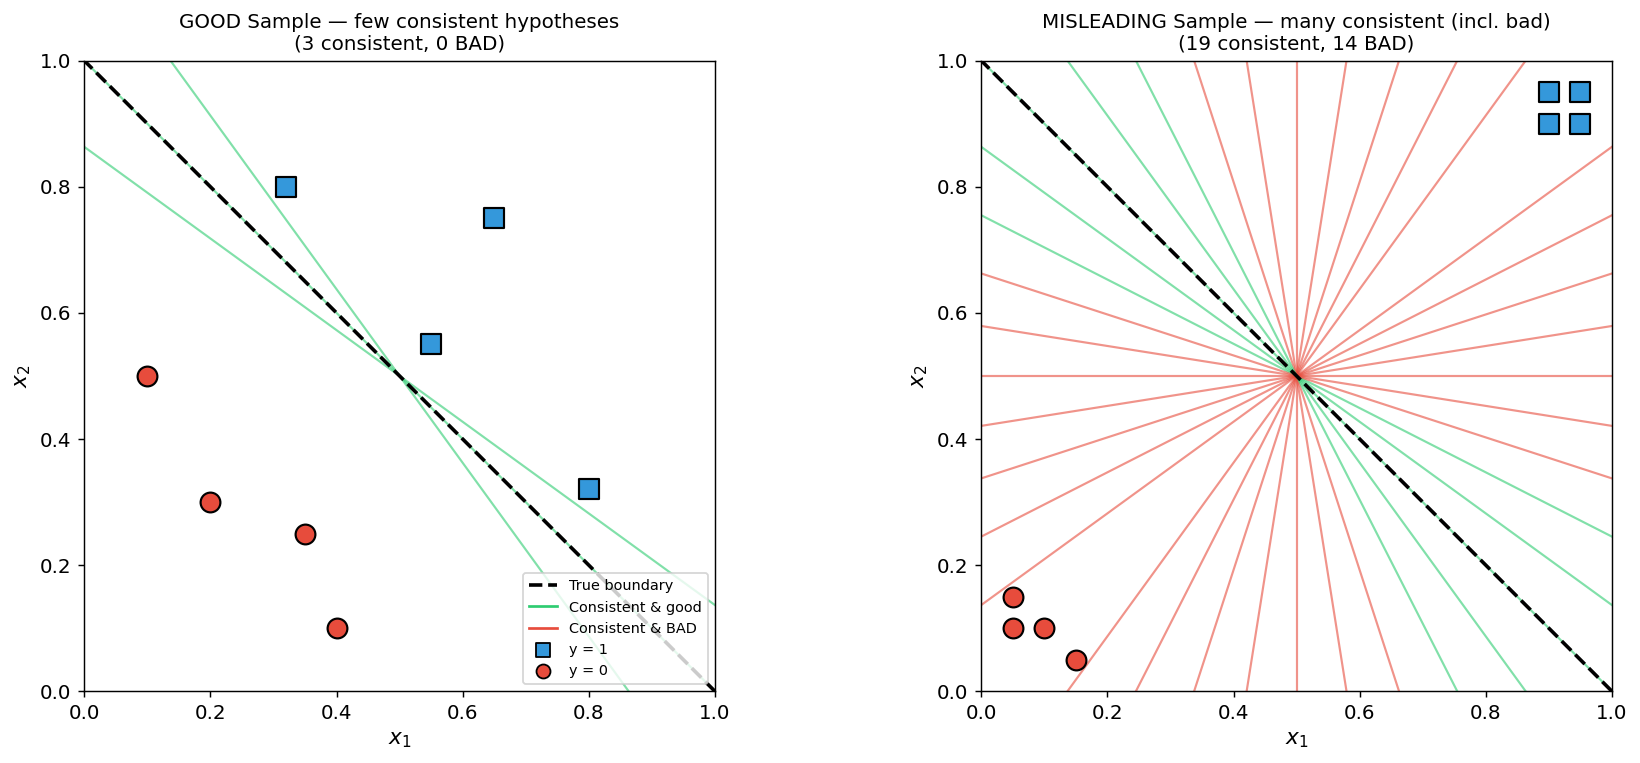

In [4]:
# Good sample vs. misleading sample in 2D

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# GOOD sample: points near boundary
x_good = np.array([
    [0.32, 0.80], [0.80, 0.32], [0.55, 0.55], [0.65, 0.75],
    [0.20, 0.30], [0.40, 0.10], [0.10, 0.50], [0.35, 0.25]])
y_good = (x_good[:,0] + x_good[:,1] >= 1).astype(int)

# MISLEADING sample: points far from boundary (corners)
x_mis = np.array([
    [0.05, 0.10], [0.15, 0.05], [0.10, 0.10], [0.05, 0.15],
    [0.90, 0.95], [0.95, 0.90], [0.90, 0.90], [0.95, 0.95]])
y_mis = (x_mis[:,0] + x_mis[:,1] >= 1).astype(int)

for panel_idx, (x_s, y_s, title) in enumerate([
        (x_good, y_good, 'GOOD Sample — few consistent hypotheses'),
        (x_mis,  y_mis,  'MISLEADING Sample — many consistent (incl. bad)')]):
    ax = axes[panel_idx]
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal')

    # True boundary
    draw_boundary(ax, TRUE_ANGLE, color='black', linewidth=2, linestyle='--',
                  zorder=2, label='True boundary')

    # Consistent hypotheses
    mask = get_consistent_mask(x_s, y_s)
    n_con, n_bad = int(mask.sum()), 0
    for i in range(H_SIZE):
        if mask[i]:
            bad = TRUE_ERRORS[i] > EPSILON + 1e-9
            if bad: n_bad += 1
            c = '#e74c3c' if bad else '#2ecc71'
            draw_boundary(ax, ANGLES[i], color=c, linewidth=1.2, alpha=0.6, zorder=1)

    # Training points
    for xi, yi in zip(x_s, y_s):
        c = '#3498db' if yi == 1 else '#e74c3c'
        mk = 's' if yi == 1 else 'o'
        ax.scatter(xi[0], xi[1], c=c, s=120, marker=mk, edgecolor='black',
                   linewidth=1.2, zorder=5)

    # Legend proxies
    if panel_idx == 0:
        ax.plot([], [], color='#2ecc71', linewidth=1.5, label='Consistent & good')
        ax.plot([], [], color='#e74c3c', linewidth=1.5, label='Consistent & BAD')
        ax.scatter([], [], c='#3498db', s=60, marker='s', edgecolor='black', label='y = 1')
        ax.scatter([], [], c='#e74c3c', s=60, marker='o', edgecolor='black', label='y = 0')
        ax.legend(fontsize=8, loc='lower right')
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
    ax.set_title(f'{title}\n({n_con} consistent, {n_bad} BAD)', fontsize=11)

plt.tight_layout()
plt.show()

---
## Slides 16–19 — The Union Bound

**Slide 16**: $\mathcal{D}(A \cup B) \leq \mathcal{D}(A) + \mathcal{D}(B)$

**Slides 18–19**: Applied to misleading samples:
$$\mathcal{D}^m\!\left(\bigcup_{h \in \mathcal{H}_B} \{S|_x : L_S(h)=0\}\right) \leq \sum_{h \in \mathcal{H}_B} \mathcal{D}^m(\{S|_x : L_S(h)=0\})$$

### Breaking Down the Union Bound Step

$$\mathcal{D}^m\!\left(\bigcup_{h \in \mathcal{H}_B} \{S|_x : L_S(h)=0\}\right) \leq \sum_{h \in \mathcal{H}_B} \mathcal{D}^m\!\left(\{S|_x : L_S(h)=0\}\right)$$

---

#### Part by Part

**Left side: $\mathcal{D}^m\!\left(\bigcup_{h \in \mathcal{H}_B} \ldots\right)$** — probability that *any* bad hypothesis survives

This is what we want to bound: the chance that the training set is misleading.

**$\bigcup_{h \in \mathcal{H}_B}$** — union = "OR"

Bad $h_1$ survives OR bad $h_2$ survives OR ... OR bad $h_k$ survives.

**Right side: $\sum_{h \in \mathcal{H}_B}$** — just add up each one separately

Pr($h_1$ survives) + Pr($h_2$ survives) + ... + Pr($h_k$ survives).

**$\leq$** — inequality, not equality

The sum overcounts because the events *overlap*: the same training set can let multiple bad hypotheses survive simultaneously. Overlapping regions get counted twice. But overcounting is fine — it gives us an upper bound.

---

#### The Whole Thing

> "The probability that *any* bad hypothesis sneaks through is at most the *sum* of the individual sneaking-through probabilities."

#### Why This Helps

Computing Pr(union) exactly requires inclusion-exclusion (subtract pairwise overlaps, add back triple overlaps...) — messy. The union bound skips all that: just add. It overcounts, but we get a clean, simple upper bound. We've reduced one hard problem to many identical easy ones.

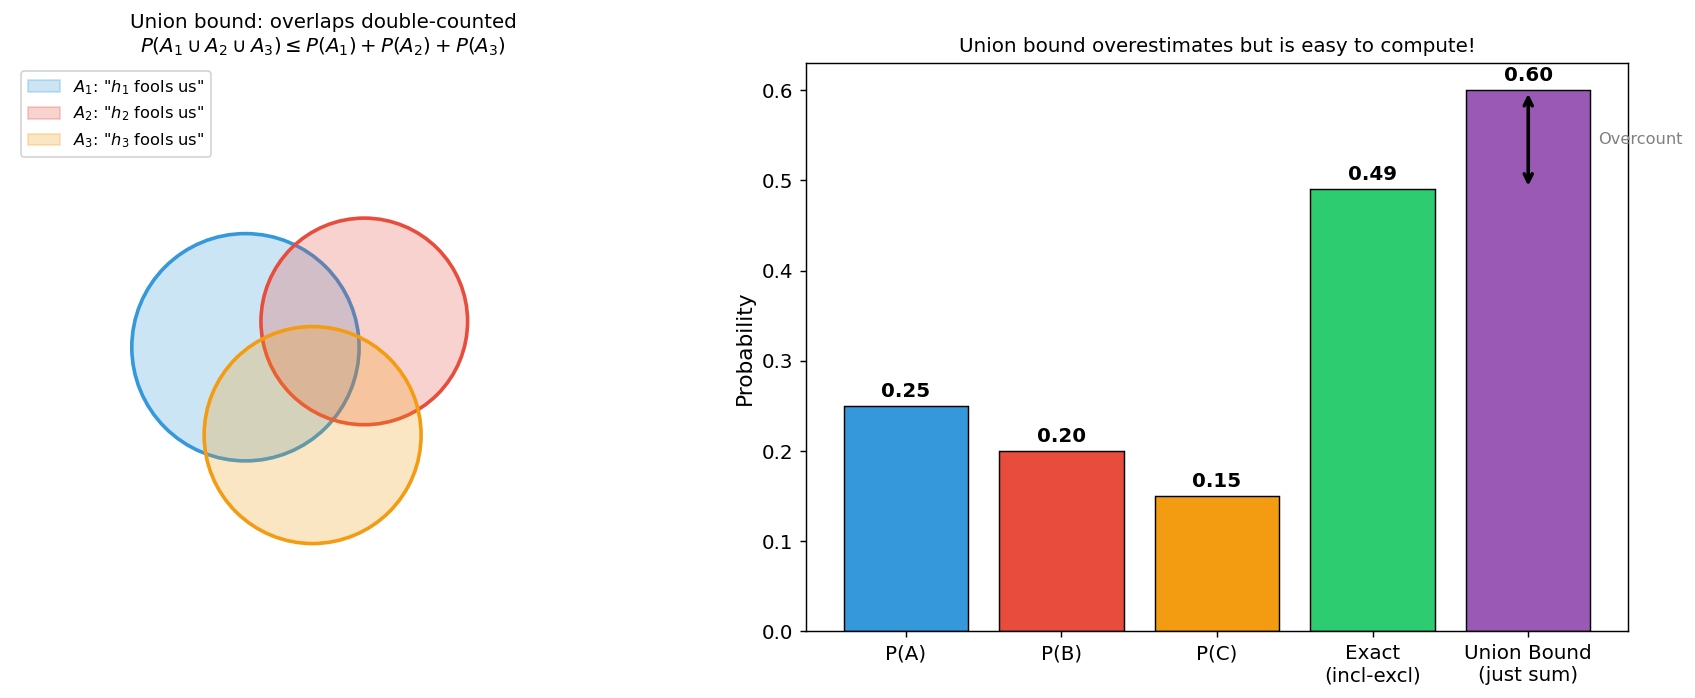

In [5]:
# Union bound: Venn diagram + numerical example

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# --- Left: Venn diagram ---
ax = axes[0]
ax.set_xlim(-0.1, 1.1); ax.set_ylim(0.0, 1.1); ax.set_aspect('equal')
for cx, cy, r, color, label in [
        (0.35, 0.55, 0.22, '#3498db', r'$A_1$: "$h_1$ fools us"'),
        (0.58, 0.60, 0.20, '#e74c3c', r'$A_2$: "$h_2$ fools us"'),
        (0.48, 0.38, 0.21, '#f39c12', r'$A_3$: "$h_3$ fools us"')]:
    ax.add_patch(Circle((cx,cy), r, alpha=0.25, color=color, label=label))
    ax.add_patch(Circle((cx,cy), r, fill=False, edgecolor=color, linewidth=2))
ax.set_title('Union bound: overlaps double-counted\n'
             r'$P(A_1 \cup A_2 \cup A_3) \leq P(A_1)+P(A_2)+P(A_3)$', fontsize=11)
ax.legend(loc='upper left', fontsize=9)
for sp in ax.spines.values(): sp.set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

# --- Right: numerical comparison ---
ax = axes[1]
pA, pB, pC = 0.25, 0.20, 0.15
exact = pA+pB+pC - 0.05-0.04-0.03 + 0.01
union = pA+pB+pC
labels = ['P(A)', 'P(B)', 'P(C)', 'Exact\n(incl-excl)', 'Union Bound\n(just sum)']
vals = [pA, pB, pC, exact, union]
cs = ['#3498db','#e74c3c','#f39c12','#2ecc71','#9b59b6']
bars = ax.bar(labels, vals, color=cs, edgecolor='black', linewidth=0.8)
for bar, val in zip(bars, vals):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
            f'{val:.2f}', ha='center', fontsize=11, fontweight='bold')
ax.annotate('', xy=(4, exact), xytext=(4, union),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax.text(4.45, (exact+union)/2, 'Overcount', fontsize=9, va='center', color='gray')
ax.set_ylabel('Probability')
ax.set_title('Union bound overestimates but is easy to compute!', fontsize=11)

plt.tight_layout()
plt.show()

---
## Slides 20–22 — Bounding the "Probability of Perfection"

For a single bad $h$ with $L_{\mathcal{D}}(h) > \epsilon$, each i.i.d. training point has
probability $\leq 1-\epsilon$ of being correctly classified. So:

$$\Pr[L_S(h)=0] = \prod_{i=1}^{m} \Pr[h(x_i)=y_i] \leq (1-\epsilon)^m$$

**Intuition**: Each point is an independent chance to *catch* the bad hypothesis.
With $m$ points, the chance none of them catch it shrinks exponentially.

### Breaking Down the i.i.d. Product

$$\Pr[L_S(h)=0] = \prod_{i=1}^{m} \Pr[h(x_i)=y_i] \leq (1-\epsilon)^m$$

---

#### Part by Part

**$L_S(h) = 0$** — bad hypothesis $h$ gets every training point right

This is the event we're bounding: $h$ "fools" the entire training set.

**$\prod_{i=1}^{m}$** — product of $m$ independent terms

Because each training point is drawn independently (i.i.d. assumption), the probability of getting *all* of them right is the product of getting *each one* right. This is where the i.i.d. assumption pays off.

**$\Pr[h(x_i) = y_i]$** — probability $h$ gets one point right

For a bad hypothesis, this is at most $1 - \epsilon$. Why? Because $h$ is bad means it has true error $> \epsilon$, so each random point has $> \epsilon$ probability of being one that $h$ gets *wrong*. That leaves $< 1 - \epsilon$ probability of getting it right.

**$(1-\epsilon)^m$** — the final bound

Multiply $(1 - \epsilon)$ by itself $m$ times. This is a number less than 1 raised to the $m$-th power, so it shrinks exponentially as $m$ grows.

---

#### The Whole Thing

> "A bad hypothesis must fool every single one of $m$ independent training points. Each point has at least an $\epsilon$ chance of catching it. The probability of dodging all $m$ traps is at most $(1-\epsilon)^m$."

#### Example

$\epsilon = 0.15$, $m = 30$: $(0.85)^{30} \approx 0.76\%$. By $m = 50$: $(0.85)^{50} \approx 0.03\%$. More data → exponentially harder to hide.

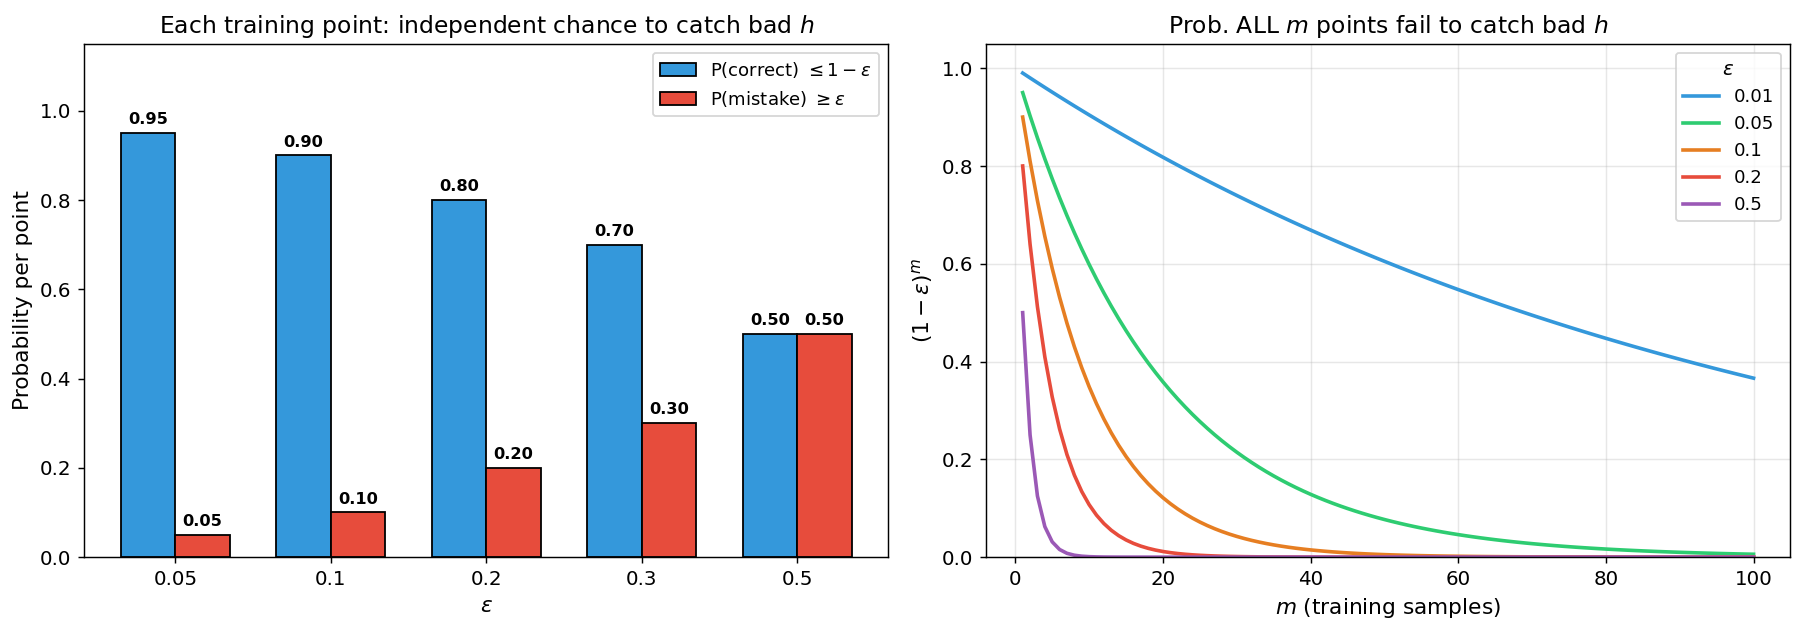

In [6]:
# Exponential decay: (1-eps)^m

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
m_range = np.arange(1, 101)

# --- Left: per-point probabilities ---
ax = axes[0]
eps_vals = [0.05, 0.1, 0.2, 0.3, 0.5]
x_pos = np.arange(len(eps_vals))
w = 0.35
b1 = ax.bar(x_pos-w/2, [1-e for e in eps_vals], w, color='#3498db',
            edgecolor='black', label=r'P(correct) $\leq 1-\epsilon$')
b2 = ax.bar(x_pos+w/2, eps_vals, w, color='#e74c3c',
            edgecolor='black', label=r'P(mistake) $\geq \epsilon$')
for bars in [b1, b2]:
    for bar in bars:
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02,
                f'{bar.get_height():.2f}', ha='center', fontsize=9, fontweight='bold')
ax.set_xticks(x_pos); ax.set_xticklabels([str(e) for e in eps_vals])
ax.set_xlabel(r'$\epsilon$'); ax.set_ylabel('Probability per point')
ax.set_title('Each training point: independent chance to catch bad $h$')
ax.legend(fontsize=10); ax.set_ylim(0, 1.15)

# --- Right: (1-eps)^m curves ---
ax = axes[1]
pal = ['#3498db','#2ecc71','#e67e22','#e74c3c','#9b59b6']
for eps, color in zip([0.01,0.05,0.1,0.2,0.5], pal):
    ax.plot(m_range, (1-eps)**m_range, label=f'{eps}', linewidth=2, color=color)
ax.set_xlabel('$m$ (training samples)'); ax.set_ylabel(r'$(1-\epsilon)^m$')
ax.set_title(r'Prob. ALL $m$ points fail to catch bad $h$')
ax.legend(title=r'$\epsilon$', fontsize=10); ax.set_ylim(0,1.05); ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## Slide 23 — A Convenient Trick: $1 - \epsilon \leq e^{-\epsilon}$

$(1-\epsilon)^m \leq e^{-\epsilon m}$

The exponential curve $e^{-\epsilon}$ is tangent to $1-\epsilon$ at $\epsilon=0$
and always stays above it.

### Breaking Down the Trick

$$1 - \epsilon \leq e^{-\epsilon} \quad \Longrightarrow \quad (1-\epsilon)^m \leq e^{-\epsilon m}$$

---

#### Part by Part

**$1 - \epsilon$** — the per-point survival probability

Each training point lets the bad hypothesis survive with probability at most $1 - \epsilon$.

**$e^{-\epsilon}$** — a slightly larger number

A standard calculus fact: $1 - x \leq e^{-x}$ for all $x \geq 0$. The two are tangent at $x = 0$, and $e^{-x}$ is always above $1 - x$.

**$(1-\epsilon)^m \leq e^{-\epsilon m}$** — raise both sides to the $m$-th power

Since $1-\epsilon \leq e^{-\epsilon}$, raising both sides to the $m$-th power preserves the inequality (both sides are positive).

---

#### The Whole Thing

> "We replace $(1-\epsilon)^m$ with the slightly larger $e^{-\epsilon m}$. This makes the bound a bit looser but makes the algebra much cleaner."

#### Why We Need This

$(1-\epsilon)^m$ is hard to invert. But $e^{-\epsilon m} \leq \delta$ is easy to solve:

$$-\epsilon m \leq \ln \delta \quad \Rightarrow \quad m \geq \frac{\ln(1/\delta)}{\epsilon}$$

The exponential form gives us a closed-form formula for $m$. That's the whole reason for this step.

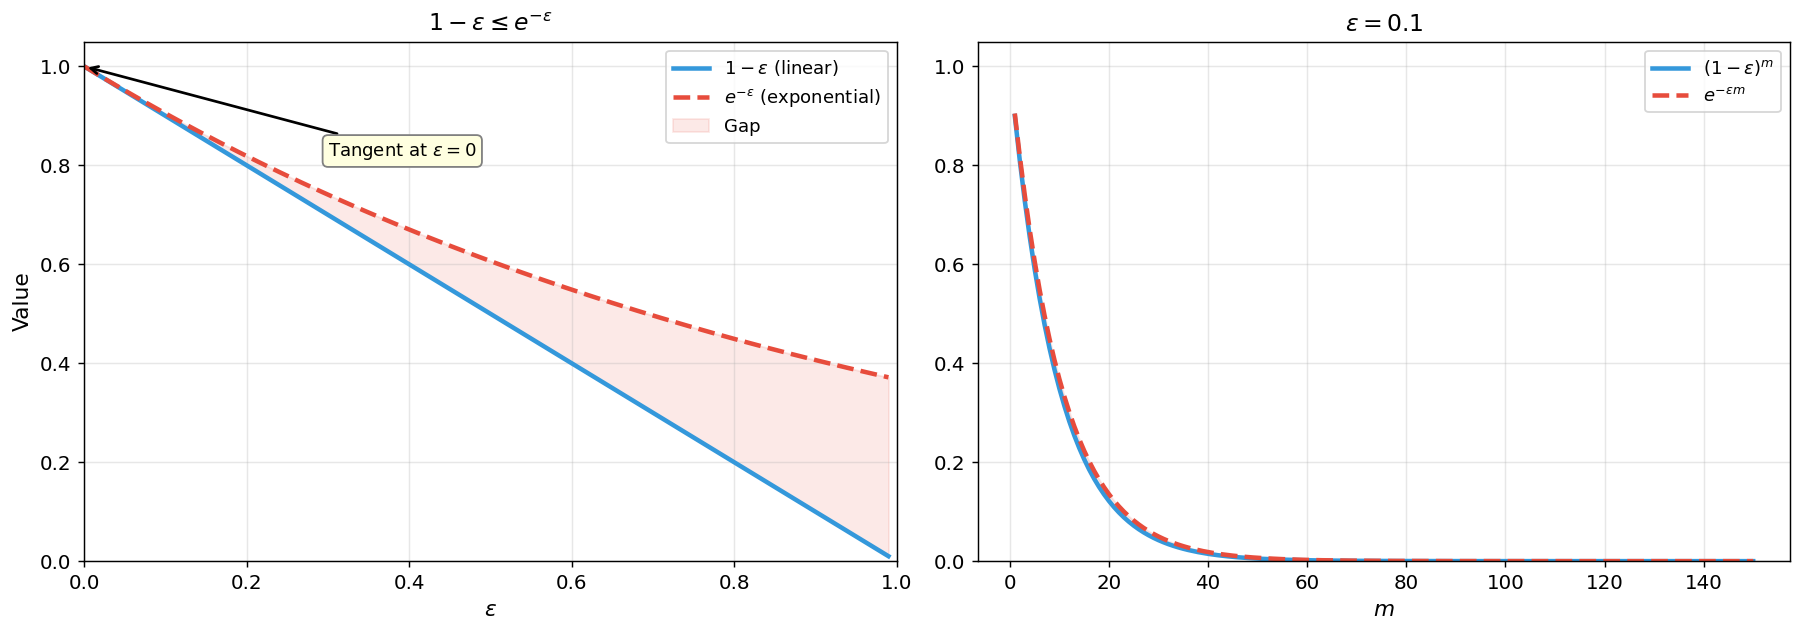

In [7]:
# Convenient trick: 1 - eps <= e^{-eps}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: 1-eps vs e^{-eps}
ax = axes[0]
er = np.linspace(0, 0.99, 500)
ax.plot(er, 1-er, label=r'$1-\epsilon$ (linear)', linewidth=2.5, color='#3498db')
ax.plot(er, np.exp(-er), label=r'$e^{-\epsilon}$ (exponential)',
        linewidth=2.5, linestyle='--', color='#e74c3c')
ax.fill_between(er, 1-er, np.exp(-er), alpha=0.12, color='#e74c3c', label='Gap')
ax.annotate('Tangent at $\\epsilon=0$', xy=(0,1), xytext=(0.3,0.82), fontsize=10,
            arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray'))
ax.set_xlabel(r'$\epsilon$'); ax.set_ylabel('Value')
ax.set_title(r'$1-\epsilon \leq e^{-\epsilon}$'); ax.legend(fontsize=10)
ax.set_xlim(0,1); ax.set_ylim(0,1.05); ax.grid(alpha=0.3)

# Right: (1-eps)^m vs e^{-eps*m}
ax = axes[1]
mr = np.arange(1, 151)
ax.plot(mr, (1-0.1)**mr, label=r'$(1-\epsilon)^m$', linewidth=2.5, color='#3498db')
ax.plot(mr, np.exp(-0.1*mr), label=r'$e^{-\epsilon m}$',
        linewidth=2.5, linestyle='--', color='#e74c3c')
ax.fill_between(mr, (1-0.1)**mr, np.exp(-0.1*mr), alpha=0.12, color='#e74c3c')
ax.set_xlabel('$m$'); ax.set_title(r'$\epsilon = 0.1$')
ax.legend(fontsize=10); ax.set_ylim(0,1.05); ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## Slides 24–26 — Putting It All Together → Sample Complexity

$$\Pr[\text{fail}]
\leq \sum_{h \in \mathcal{H}_B} e^{-\epsilon m}
\leq |\mathcal{H}| e^{-\epsilon m}$$

Setting $\leq \delta$ and solving:
$$m \geq \frac{\log(|\mathcal{H}|/\delta)}{\epsilon}$$

**Slide 26 — PAC Learnability**: sample complexity
$m_{\mathcal{H}}(\epsilon,\delta) \leq \lceil \log(|\mathcal{H}|/\delta)/\epsilon \rceil$

### Breaking Down the Combined Bound

$$\Pr[\text{fail}] \leq \sum_{h \in \mathcal{H}_B} e^{-\epsilon m} \leq |\mathcal{H}| \, e^{-\epsilon m}$$

---

#### Part by Part

**$\sum_{h \in \mathcal{H}_B} e^{-\epsilon m}$** — sum the per-hypothesis bounds

From the union bound: add up $e^{-\epsilon m}$ once for each bad hypothesis. Since $e^{-\epsilon m}$ doesn't depend on which $h$ we're looking at, every term is the same.

**$|\mathcal{H}_B|$ terms, each equal to $e^{-\epsilon m}$** — so the sum simplifies

$= |\mathcal{H}_B| \cdot e^{-\epsilon m}$.

**$\leq |\mathcal{H}| \, e^{-\epsilon m}$** — replace $|\mathcal{H}_B|$ with $|\mathcal{H}|$

We don't know exactly how many bad hypotheses there are, but there can't be more than the total number $|\mathcal{H}|$. One more overcount, but it removes the unknown.

---

### Solving for Sample Complexity

$$|\mathcal{H}| \, e^{-\epsilon m} \leq \delta$$

---

#### Step by Step

**Divide both sides by $|\mathcal{H}|$:**

$$e^{-\epsilon m} \leq \frac{\delta}{|\mathcal{H}|}$$

**Take natural log of both sides:**

$$-\epsilon m \leq \ln\!\left(\frac{\delta}{|\mathcal{H}|}\right)$$

**Multiply by $-1$ (flip the inequality):**

$$\epsilon m \geq \ln\!\left(\frac{|\mathcal{H}|}{\delta}\right)$$

**Divide by $\epsilon$:**

$$m \geq \frac{\ln(|\mathcal{H}|/\delta)}{\epsilon}$$

---

### Breaking Down the Final Formula

$$m_{\mathcal{H}}(\epsilon,\delta) \leq \left\lceil \frac{\ln(|\mathcal{H}|/\delta)}{\epsilon} \right\rceil$$

---

#### Part by Part

**$m_{\mathcal{H}}(\epsilon, \delta)$** — sample complexity

The minimum number of training examples needed to guarantee PAC learning.

**$\ln(|\mathcal{H}|/\delta)$** — the numerator

Combines model class size and confidence. Grows logarithmically — doubling $|\mathcal{H}|$ only adds $\ln 2 \approx 0.69$ to the numerator.

**$\epsilon$** — the denominator

Accuracy demand. Halving $\epsilon$ *doubles* $m$. Accuracy is the expensive knob.

**$\lceil \cdot \rceil$** — ceiling function

Round up, because you can't draw a fractional number of training points.

---

#### In Our Example

$|\mathcal{H}| = 21$, $\epsilon = 0.146$, $\delta = 0.05$:

$$m^* = \left\lceil \frac{\ln(21/0.05)}{0.146} \right\rceil = \left\lceil \frac{\ln(420)}{0.146} \right\rceil = \left\lceil \frac{6.04}{0.146} \right\rceil = 42$$

42 training examples guarantee, with ≥ 95% probability, that ERM picks a line with true error ≤ 14.6%.

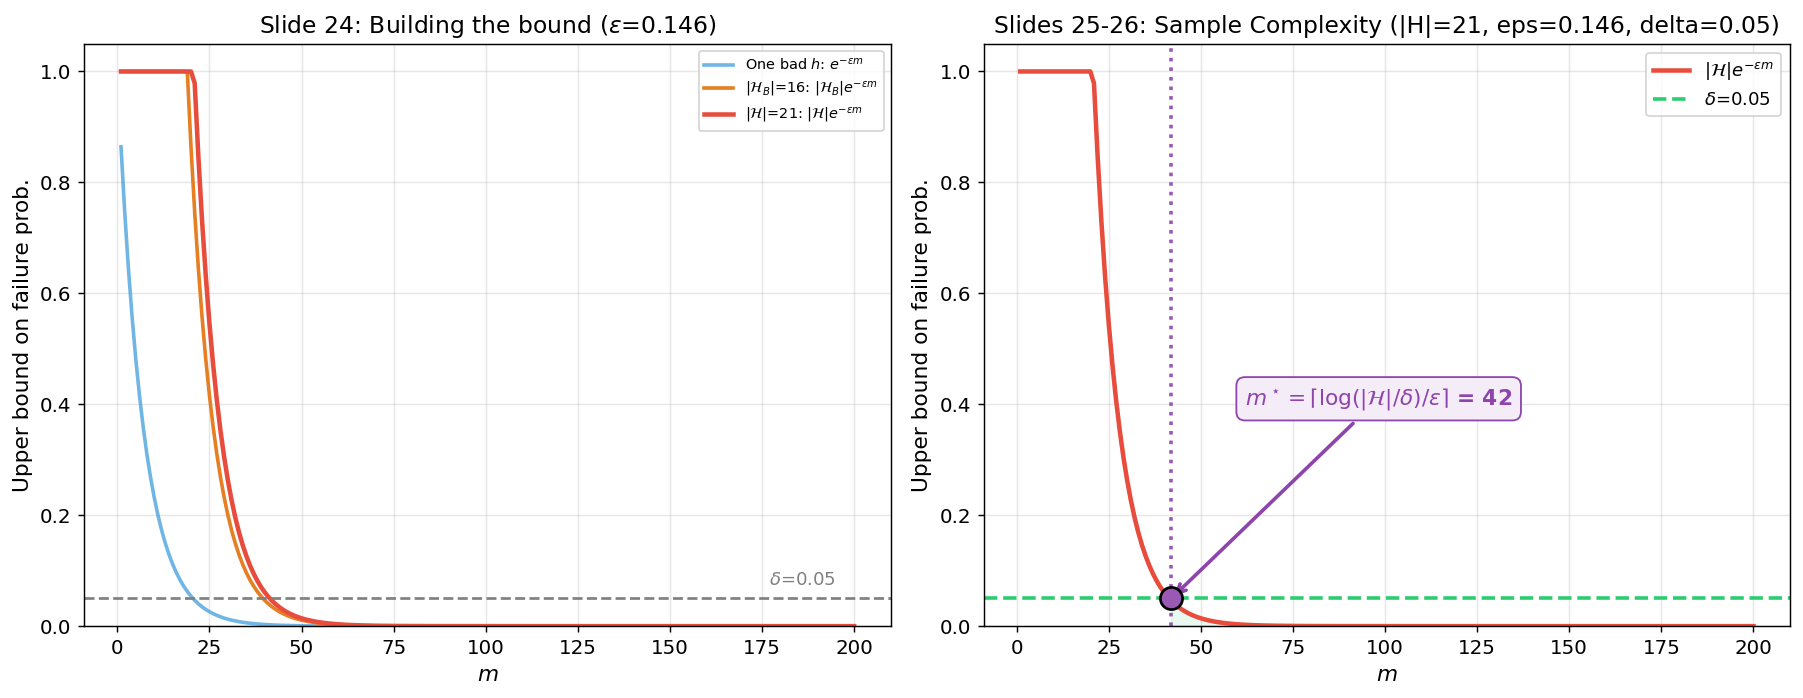


m* = ceil(log(21/0.05) / 0.146) = 42


In [8]:
# Build the bound layer by layer + find m*

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
mr = np.arange(1, 201); eps = EPSILON; delta = 0.05
H_B_count = int(np.sum(TRUE_ERRORS > eps + 1e-9))

# Left: layer by layer
ax = axes[0]
ax.plot(mr, np.minimum(1, np.exp(-eps*mr)), lw=2, color='#3498db', alpha=0.7,
        label=r'One bad $h$: $e^{-\epsilon m}$')
ax.plot(mr, np.minimum(1, H_B_count*np.exp(-eps*mr)), lw=2, color='#e67e22',
        label=f'$|\\mathcal{{H}}_B|$={H_B_count}: ' + r'$|\mathcal{H}_B|e^{-\epsilon m}$')
ax.plot(mr, np.minimum(1, H_SIZE*np.exp(-eps*mr)), lw=2.5, color='#e74c3c',
        label=f'$|\\mathcal{{H}}|$={H_SIZE}: ' + r'$|\mathcal{H}|e^{-\epsilon m}$')
ax.axhline(y=delta, color='gray', ls='--', lw=1.5)
ax.text(195, delta+0.025, f'$\\delta$={delta}', fontsize=10, ha='right', color='gray')
ax.set_xlabel('$m$'); ax.set_ylabel('Upper bound on failure prob.')
ax.set_title(r'Slide 24: Building the bound ($\epsilon$=' + f'{eps})')
ax.legend(fontsize=8, loc='upper right'); ax.set_ylim(0,1.05); ax.grid(alpha=0.3)

# Right: sample complexity
ax = axes[1]
bc = np.minimum(1, H_SIZE*np.exp(-eps*mr))
ax.plot(mr, bc, lw=2.5, color='#e74c3c', label=r'$|\mathcal{H}|e^{-\epsilon m}$')
ax.axhline(y=delta, color='#2ecc71', ls='--', lw=2, label=f'$\\delta$={delta}')
m_star = math.ceil(math.log(H_SIZE/delta) / eps)
ax.axvline(x=m_star, color='#9b59b6', ls=':', lw=2)
ax.scatter([m_star], [delta], s=150, color='#9b59b6', zorder=5,
           edgecolor='black', linewidth=1.5)
ax.annotate(r'$m^\star = \lceil \log(|\mathcal{H}|/\delta)/\epsilon \rceil$'
            + f' = {m_star}',
            xy=(m_star, delta), xytext=(m_star+20, delta+0.35),
            fontsize=12, fontweight='bold', color='#8e44ad',
            arrowprops=dict(arrowstyle='->', lw=2, color='#8e44ad'),
            bbox=dict(boxstyle='round,pad=0.4', fc='#f4ecf7', ec='#8e44ad'))
ax.fill_between(mr[mr>=m_star], 0, bc[mr>=m_star], alpha=0.1, color='#2ecc71')
ax.set_xlabel('$m$'); ax.set_ylabel('Upper bound on failure prob.')
ax.set_title(f'Slides 25-26: Sample Complexity (|H|={H_SIZE}, eps={eps}, delta={delta})')
ax.legend(fontsize=10, loc='upper right'); ax.set_ylim(0,1.05); ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nm* = ceil(log({H_SIZE}/{delta}) / {eps}) = {m_star}")

---
## Slides 27–29 — Examples: Varying $\epsilon$, $\delta$, $|\mathcal{H}|$

$$m \leq \left\lceil \frac{\log(|\mathcal{H}|/\delta)}{\epsilon} \right\rceil$$

- **Slide 27**: $m \propto 1/\epsilon$ (hyperbolic)
- **Slide 28**: $m \propto \log(1/\delta)$ (logarithmic)
- **Slide 29**: $m \propto \log|\mathcal{H}|$ (logarithmic)

### Breaking Down Each Parameter's Effect

$$m \leq \left\lceil \frac{\ln(|\mathcal{H}|/\delta)}{\epsilon} \right\rceil$$

---

#### Varying $\epsilon$ (Slide 27): $m \propto 1/\epsilon$

**$\epsilon$ appears in the denominator** — so making $\epsilon$ smaller makes $m$ bigger.

- Halving $\epsilon$ (want twice the accuracy) → $m$ doubles.
- This is a **hyperbolic** relationship: $m$ blows up as $\epsilon \to 0$.
- Accuracy is the *expensive* knob.

#### Varying $\delta$ (Slide 28): $m \propto \ln(1/\delta)$

**$\delta$ appears inside a log** — so making $\delta$ smaller barely increases $m$.

- Going from $\delta = 0.05$ (95% confidence) to $\delta = 0.01$ (99% confidence) only adds $\ln(5) \approx 1.6$ to the numerator.
- This is a **logarithmic** relationship: confidence is *cheap*.

#### Varying $|\mathcal{H}|$ (Slide 29): $m \propto \ln |\mathcal{H}|$

**$|\mathcal{H}|$ also appears inside a log** — so bigger model classes barely need more data.

- Going from 100 models to 1,000,000 models: $\ln$ goes from 4.6 to 13.8. That's only ~3× more data for 10,000× more models.
- This is **logarithmic**: model complexity is also *cheap*.

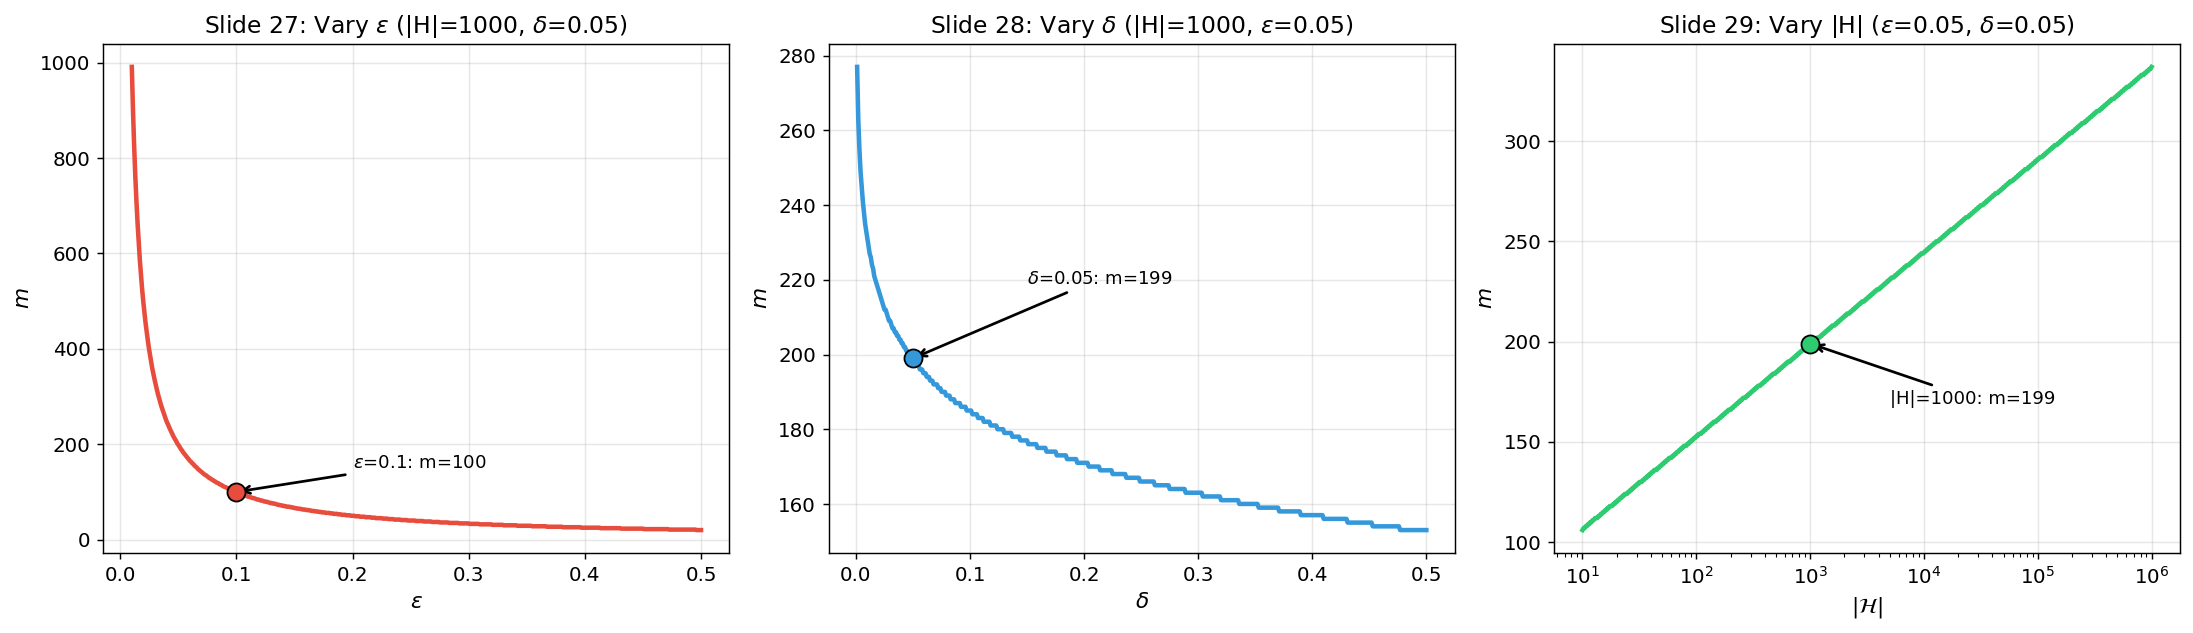

In [9]:
# Reproduce slide parameter sweeps

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
H_p, d_p = 1000, 0.05

# Slide 27: vary eps
ax = axes[0]
epsilons = np.linspace(0.01, 0.5, 500)
ax.plot(epsilons, np.ceil(np.log(H_p/d_p)/epsilons), lw=2.5, color='#e74c3c')
ep_pt = 0.1; mp_pt = math.ceil(math.log(H_p/d_p)/ep_pt)
ax.scatter([ep_pt],[mp_pt], s=100, color='#e74c3c', zorder=5, edgecolor='black')
ax.annotate(f'$\\epsilon$={ep_pt}: m={mp_pt}', xy=(ep_pt,mp_pt),
            xytext=(ep_pt+0.1,mp_pt+50), fontsize=10,
            arrowprops=dict(arrowstyle='->', lw=1.5))
ax.set_xlabel(r'$\epsilon$'); ax.set_ylabel('$m$')
ax.set_title(f'Slide 27: Vary $\\epsilon$ (|H|={H_p}, $\\delta$={d_p})'); ax.grid(alpha=0.3)

# Slide 28: vary delta
ax = axes[1]
deltas = np.linspace(0.001, 0.5, 500)
ax.plot(deltas, np.ceil(np.log(H_p/deltas)/0.05), lw=2.5, color='#3498db')
dp = 0.05; mp2 = math.ceil(math.log(H_p/dp)/0.05)
ax.scatter([dp],[mp2], s=100, color='#3498db', zorder=5, edgecolor='black')
ax.annotate(f'$\\delta$={dp}: m={mp2}', xy=(dp,mp2),
            xytext=(dp+0.1,mp2+20), fontsize=10,
            arrowprops=dict(arrowstyle='->', lw=1.5))
ax.set_xlabel(r'$\delta$'); ax.set_ylabel('$m$')
ax.set_title(f'Slide 28: Vary $\\delta$ (|H|={H_p}, $\\epsilon$=0.05)'); ax.grid(alpha=0.3)

# Slide 29: vary |H|
ax = axes[2]
Hs = np.logspace(1, 6, 500)
ax.plot(Hs, np.ceil(np.log(Hs/d_p)/0.05), lw=2.5, color='#2ecc71')
hp = 1000; mp3 = math.ceil(math.log(hp/d_p)/0.05)
ax.scatter([hp],[mp3], s=100, color='#2ecc71', zorder=5, edgecolor='black')
ax.annotate(f'|H|={hp}: m={mp3}', xy=(hp,mp3),
            xytext=(hp*5,mp3-30), fontsize=10,
            arrowprops=dict(arrowstyle='->', lw=1.5))
ax.set_xlabel(r'$|\mathcal{H}|$'); ax.set_ylabel('$m$')
ax.set_title(f'Slide 29: Vary |H| ($\\epsilon$=0.05, $\\delta$={d_p})'); ax.set_xscale('log')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## Slides 30–33 — The Unrealizable Case (Preview)

When realizability fails (model mismatch or label noise), $L_S(h_S)=0$ is no longer guaranteed.
A more powerful theory is needed.

### What Breaks Without Realizability?

---

#### The Realizability Assumption

**$\exists\, h^\star \in \mathcal{H}$ with $L_{\mathcal{D}}(h^\star) = 0$** — there is a perfect model on our menu.

Our entire proof depended on this:
- ERM finds some $h_S$ with $L_S(h_S) = 0$ → guaranteed because $h^\star$ always gets zero training error.
- We only needed to worry about *which* zero-training-error hypothesis ERM picks.

#### When It Fails

**Model mismatch:** The true boundary is curved, but $\mathcal{H}$ only has straight lines. No $h \in \mathcal{H}$ achieves $L_{\mathcal{D}}(h) = 0$.

**Label noise:** Some training labels are flipped by measurement error. Now even $h^\star$ gets $L_S(h^\star) > 0$, so ERM can't achieve zero training error at all.

#### The Consequence

The proof breaks at the very first step. We defined failure as "ERM picks from $\mathcal{H}_B$" and bounded it via misleading samples. Without realizability, ERM doesn't necessarily achieve $L_S = 0$, and the whole argument collapses.

#### What Comes Next

The **agnostic PAC** framework handles this. Instead of comparing to perfection, it compares to the *best model in $\mathcal{H}$* — even if that best model isn't perfect. That requires different (harder) tools.

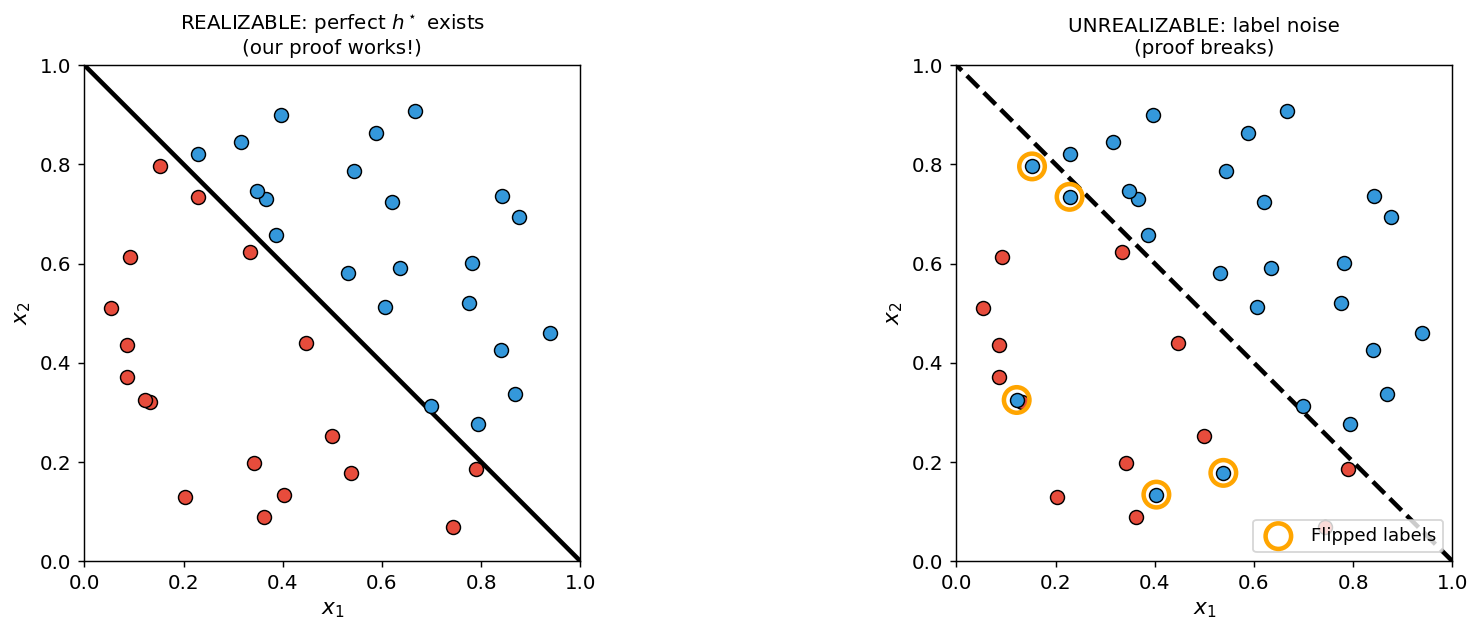

In [10]:
# Realizable vs. unrealizable in 2D

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax_idx, (title, flip) in enumerate([
        ('REALIZABLE: perfect $h^\\star$ exists\n(our proof works!)', False),
        ('UNREALIZABLE: label noise\n(proof breaks)', True)]):
    ax = axes[ax_idx]
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal')
    np.random.seed(10)
    xp = np.random.uniform(0.05, 0.95, (40, 2))
    yp = (xp[:,0] + xp[:,1] >= 1).astype(int)
    if flip:
        flip_idx = [3, 10, 18, 25, 33]
        for i in flip_idx:
            yp[i] = 1 - yp[i]
    for xi, yi in zip(xp, yp):
        c = '#3498db' if yi == 1 else '#e74c3c'
        ax.scatter(xi[0], xi[1], c=c, s=60, edgecolor='black', linewidth=0.8, zorder=5)
    draw_boundary(ax, TRUE_ANGLE, color='black', linewidth=2.5,
                  linestyle=('--' if flip else '-'))
    if flip:
        for i in flip_idx:
            ax.scatter(xp[i,0], xp[i,1], s=200, facecolors='none',
                       edgecolors='orange', linewidth=2.5, zorder=6)
        ax.scatter([], [], s=200, facecolors='none', edgecolors='orange',
                   linewidth=2.5, label='Flipped labels')
        ax.legend(fontsize=10, loc='lower right')
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
    ax.set_title(title, fontsize=11)

plt.tight_layout()
plt.show()

---
## Bonus — Empirical Verification: Does the Bound Actually Hold?

For each $m$, we run 5000 ERM trials on 2D data and check if the empirical
failure rate stays below $|\mathcal{H}|e^{-\epsilon m}$.

### What This Experiment Does

---

#### The Theoretical Bound

$$\Pr[\text{fail}] \leq |\mathcal{H}| \, e^{-\epsilon m}$$

This is a *worst-case upper bound*. It must hold for any distribution. It says nothing about what the failure rate *actually is* — only that it can't be larger than this.

#### The Empirical Check

For each value of $m$, we repeat 5,000 times:
1. Draw $m$ random training points.
2. Run ERM: find all consistent hypotheses, pick one at random.
3. Check: does the chosen hypothesis have true error $> \epsilon$? If yes, count it as a failure.

**Empirical failure rate** = (number of failures) / 5,000.

#### What to Look For

- **Red line** (theory) should always be **above** blue line (empirical). If not, the bound is wrong.
- **Gap** between them = how conservative the bound is. Bigger gap = more pessimistic bound.
- Both should converge to 0 as $m$ grows.

m=  5:  empirical=0.3272  theory=1.0000  [HOLDS]
m= 10:  empirical=0.1150  theory=1.0000  [HOLDS]
m= 15:  empirical=0.0424  theory=1.0000  [HOLDS]
m= 20:  empirical=0.0144  theory=1.0000  [HOLDS]
m= 30:  empirical=0.0018  theory=0.2630  [HOLDS]
m= 50:  empirical=0.0002  theory=0.0142  [HOLDS]
m= 75:  empirical=0.0000  theory=0.0004  [HOLDS]
m=100:  empirical=0.0000  theory=0.0000  [HOLDS]
m=150:  empirical=0.0000  theory=0.0000  [HOLDS]


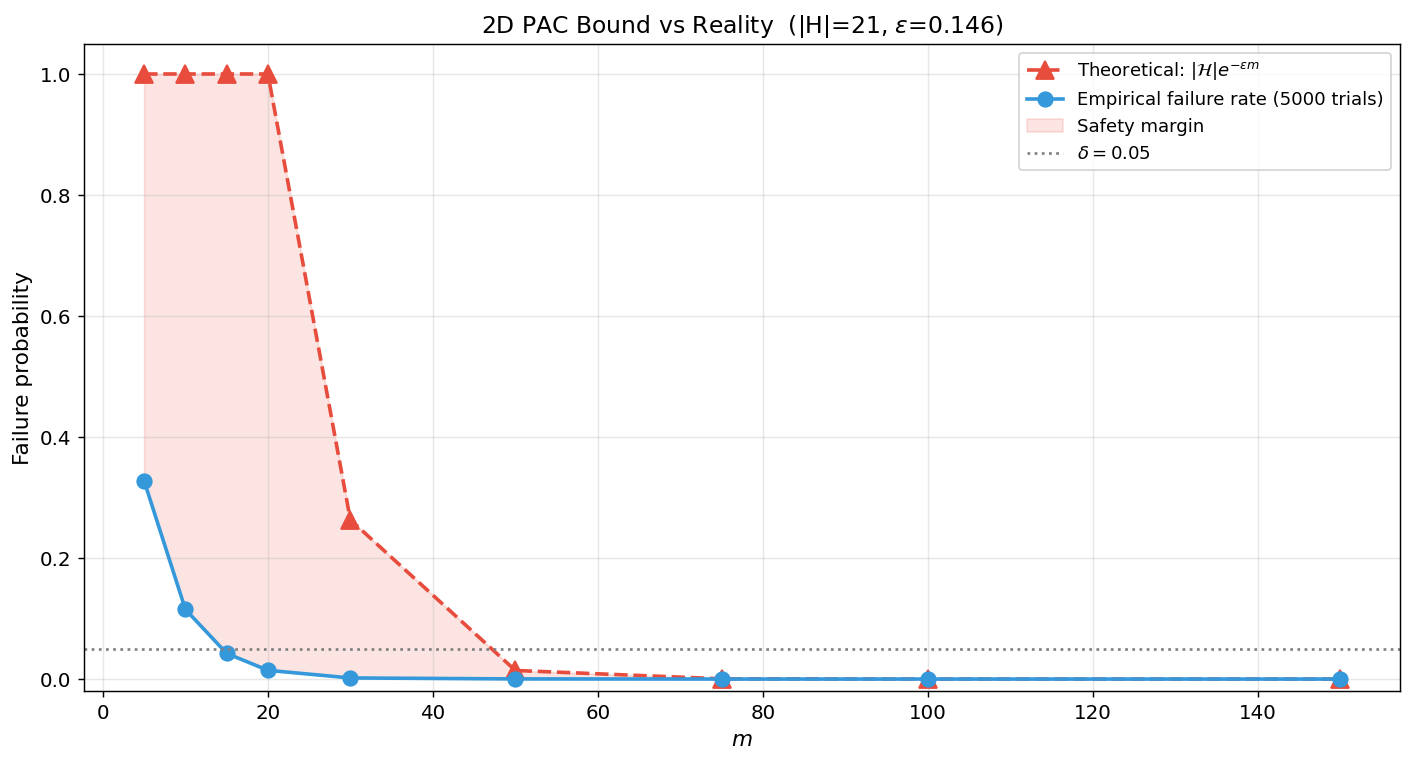

In [11]:
np.random.seed(42)
epsilon = EPSILON
n_trials = 5000
m_values = [5, 10, 15, 20, 30, 50, 75, 100, 150]

emp_fail = []
theo_bound = []

for m in m_values:
    failures = 0
    for _ in range(n_trials):
        x_tr = np.random.uniform(0, 1, (m, 2))
        y_tr = (x_tr[:,0] + x_tr[:,1] >= 1).astype(int)
        mask = get_consistent_mask(x_tr, y_tr)
        consistent_idx = np.where(mask)[0]
        chosen = np.random.choice(consistent_idx)
        if TRUE_ERRORS[chosen] > epsilon:
            failures += 1
    ef = failures / n_trials
    tb = min(1.0, H_SIZE * np.exp(-epsilon * m))
    emp_fail.append(ef)
    theo_bound.append(tb)
    tag = 'HOLDS' if ef <= tb else 'VIOLATED!'
    print(f"m={m:>3d}:  empirical={ef:.4f}  theory={tb:.4f}  [{tag}]")

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(m_values, theo_bound, '^--', markersize=10, lw=2, color='#e74c3c',
        label=r'Theoretical: $|\mathcal{H}|e^{-\epsilon m}$')
ax.plot(m_values, emp_fail, 'o-', markersize=8, lw=2, color='#3498db',
        label=f'Empirical failure rate ({n_trials} trials)')
ax.fill_between(m_values, emp_fail, theo_bound, alpha=0.15, color='#e74c3c',
                label='Safety margin')
ax.axhline(y=0.05, color='gray', ls=':', lw=1.5, label=r'$\delta = 0.05$')
ax.set_xlabel('$m$', fontsize=12); ax.set_ylabel('Failure probability', fontsize=12)
ax.set_title(f'2D PAC Bound vs Reality  (|H|={H_SIZE}, $\\epsilon$={epsilon})', fontsize=13)
ax.legend(fontsize=10, loc='upper right')
ax.set_ylim(-0.02, 1.05); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## Bonus — Zooming In: Individual ERM Trials in 2D

For $m = 5$, $15$, and $50$, we show the training data and ALL 21 decision boundaries:
- **Green** = consistent & good
- **Red** = consistent & BAD
- **Gray** = inconsistent (ruled out)

### Reading the Panels

---

#### Color Code

| Color | Meaning | ERM can pick it? |
|-------|---------|-----------------|
| **Green** | Consistent with training data AND low true error | Yes — and that's fine |
| **Red** | Consistent with training data BUT high true error | Yes — and that's the danger |
| **Gray** | Inconsistent (makes ≥ 1 mistake on training data) | No — ERM eliminates it |

#### What to Watch

- **$m = 5$**: Few data points → many lines (green AND red) are still consistent. ERM could easily pick a bad one.
- **$m = 15$**: More data points → most red lines have been caught. Only a few bad ones remain.
- **$m = 50$**: Lots of data → nearly all bad lines are eliminated. ERM is forced to pick a good one.

#### The Punchline

More data = more chances to catch bad hypotheses = fewer survivors = safer ERM. This is exactly the $(1 - \epsilon)^m$ decay in action.

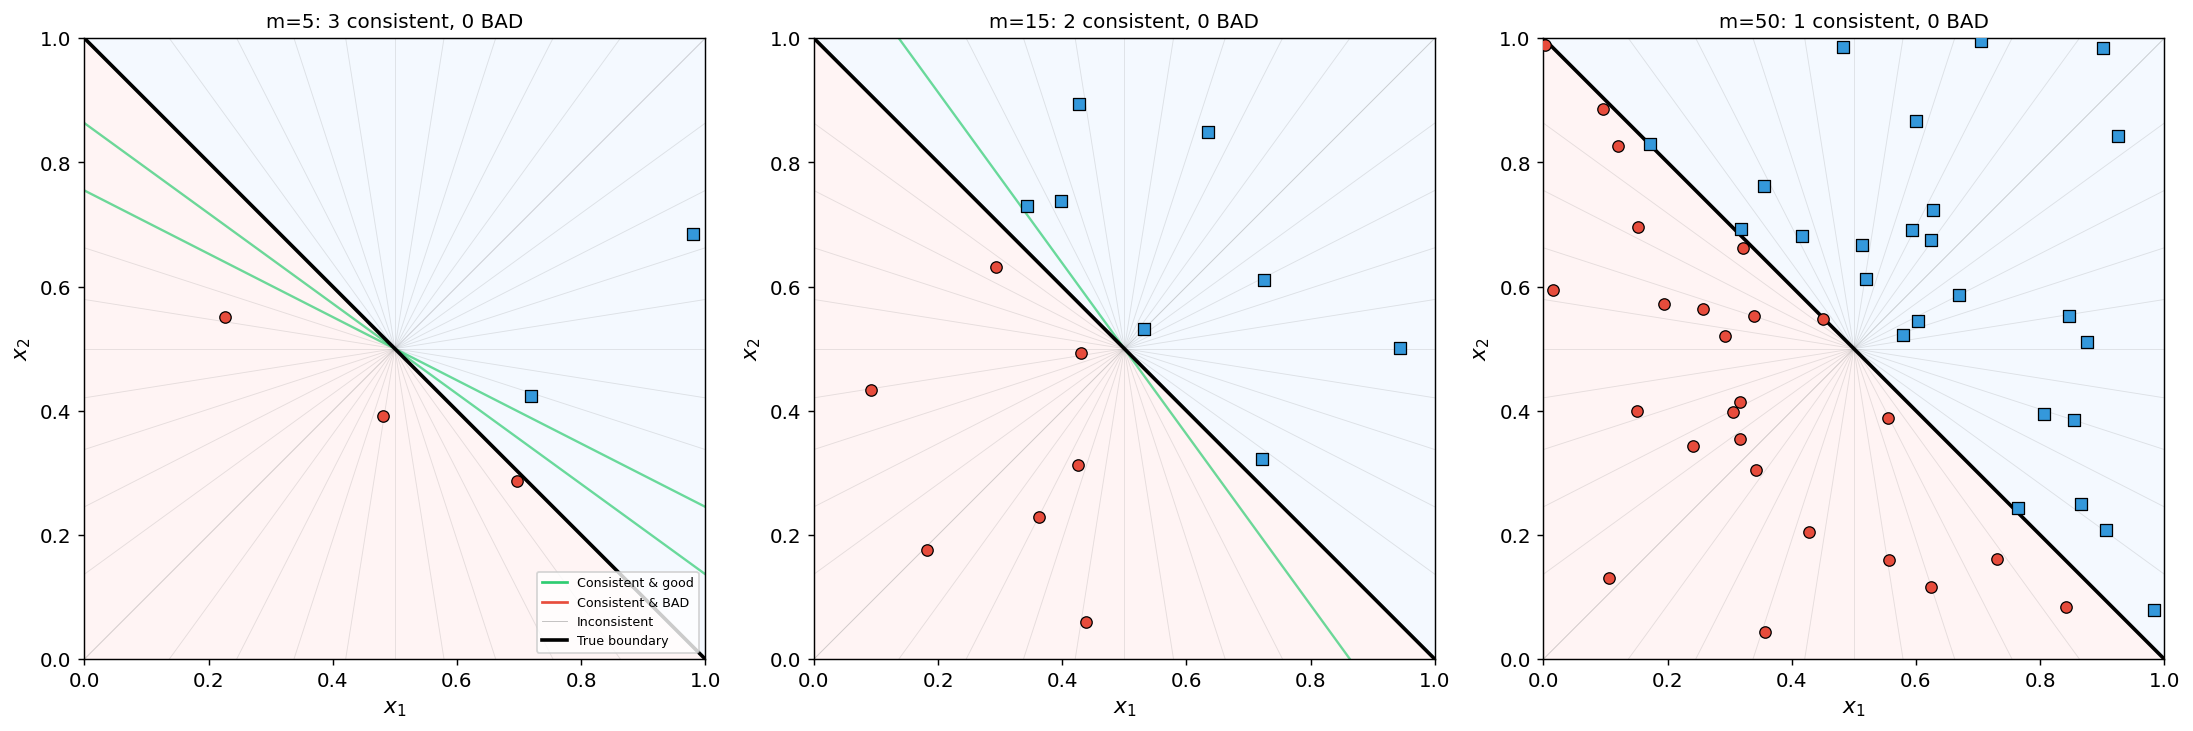

More data -> bad hypotheses get ruled out!


In [12]:
np.random.seed(123)
fig, axes = plt.subplots(1, 3, figsize=(17, 5.5))

for idx, m in enumerate([5, 15, 50]):
    ax = axes[idx]
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal')
    x_tr = np.random.uniform(0, 1, (m, 2))
    y_tr = (x_tr[:,0] + x_tr[:,1] >= 1).astype(int)
    mask = get_consistent_mask(x_tr, y_tr)

    # True class background
    grid = np.linspace(0, 1, 200)
    G1, G2 = np.meshgrid(grid, grid)
    ax.contourf(G1, G2, (G1+G2>=1).astype(int), levels=[-0.5,0.5,1.5],
                colors=['#ffcccc','#cce5ff'], alpha=0.2)

    # Draw all 21 hypotheses
    n_con, n_bad = 0, 0
    for i in range(H_SIZE):
        if mask[i]:
            n_con += 1
            bad = TRUE_ERRORS[i] > EPSILON + 1e-9
            if bad: n_bad += 1
            c = '#e74c3c' if bad else '#2ecc71'
            draw_boundary(ax, ANGLES[i], color=c, linewidth=1.3, alpha=0.7)
        else:
            draw_boundary(ax, ANGLES[i], color='gray', linewidth=0.5, alpha=0.2)

    # True boundary
    draw_boundary(ax, TRUE_ANGLE, color='black', linewidth=2, zorder=3)

    # Training points
    for xi, yi in zip(x_tr, y_tr):
        c = '#3498db' if yi == 1 else '#e74c3c'
        mk = 's' if yi == 1 else 'o'
        ax.scatter(xi[0], xi[1], c=c, s=40, marker=mk, edgecolor='black',
                   linewidth=0.7, zorder=5)

    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
    ax.set_title(f'm={m}: {n_con} consistent, {n_bad} BAD', fontsize=11)

    if idx == 0:
        ax.plot([], [], color='#2ecc71', lw=1.5, label='Consistent & good')
        ax.plot([], [], color='#e74c3c', lw=1.5, label='Consistent & BAD')
        ax.plot([], [], color='gray', lw=0.5, alpha=0.5, label='Inconsistent')
        ax.plot([], [], color='black', lw=2, label='True boundary')
        ax.legend(fontsize=7, loc='lower right')

plt.tight_layout()
plt.show()
print("More data -> bad hypotheses get ruled out!")

---
## Summary — The PAC Learning Story (Slide 33)

### Assumptions
- Finite $\mathcal{H}$ with $|\mathcal{H}| < \infty$,  Realizability,  ERM returns $h_S$ with $L_S(h_S)=0$

### The Proof Chain

| Slide(s) | Step | Result |
|----------|------|--------|
| **11** | Define bad: $\mathcal{H}_B = \{h : L_{\mathcal{D}}(h) > \epsilon\}$ | Failure = ERM picks from $\mathcal{H}_B$ |
| **13–15** | Failure $\subseteq$ misleading samples | $\Pr[\text{fail}] \leq \Pr[S \in M]$ |
| **16–19** | **Union bound** | $\leq \sum_{h \in \mathcal{H}_B} \Pr[L_S(h)=0]$ |
| **20–22** | **i.i.d.** + bad definition | $\Pr[L_S(h)=0] \leq (1-\epsilon)^m$ |
| **23** | **Trick**: $1-\epsilon \leq e^{-\epsilon}$ | $\leq e^{-\epsilon m}$ per bad $h$ |
| **24** | **Count** | $\Pr[\text{fail}] \leq |\mathcal{H}|e^{-\epsilon m}$ |
| **25–26** | **Solve** for $m$ | $m \geq \log(|\mathcal{H}|/\delta)/\epsilon$ |

### The Result
$$\boxed{m_{\mathcal{H}}(\epsilon,\delta) \leq \left\lceil \frac{\log(|\mathcal{H}|/\delta)}{\epsilon} \right\rceil}$$

### Key Intuitions
- **More data** → exponentially harder for bad hypotheses to "get lucky"
- **Union bound** → sum over bad hypotheses (overcounts but works)
- **$\log|\mathcal{H}|$** → class size matters only logarithmically
- **Distribution-free** → works for any $\mathcal{D}$, hence conservative

### The Complete Proof Chain (Symbol by Symbol)

---

| Step | What we write | What it means |
|------|--------------|---------------|
| **Start** | $\Pr[\text{ERM fails}]$ | Probability ERM picks a bad hypothesis |
| **⊆ misleading** | $\leq \Pr[S \in M]$ | Can only happen if training set is misleading |
| **Union bound** | $\leq \sum_{h \in \mathcal{H}_B} \Pr[L_S(h) = 0]$ | Sum over each bad hypothesis |
| **i.i.d.** | $\leq \sum_{h \in \mathcal{H}_B} (1-\epsilon)^m$ | Each point is an independent trap |
| **Exp trick** | $\leq \sum_{h \in \mathcal{H}_B} e^{-\epsilon m}$ | Replace with cleaner bound |
| **Count** | $\leq |\mathcal{H}| \cdot e^{-\epsilon m}$ | At most $|\mathcal{H}|$ bad hypotheses |
| **Set $\leq \delta$** | $|\mathcal{H}| e^{-\epsilon m} \leq \delta$ | We want failure prob. ≤ $\delta$ |
| **Solve** | $m \geq \ln(|\mathcal{H}|/\delta) / \epsilon$ | Minimum training set size |

---

#### Reading the Final Answer

$$\boxed{m \geq \frac{\ln(|\mathcal{H}|/\delta)}{\epsilon}}$$

- **$\ln(|\mathcal{H}|/\delta)$**: more models or higher confidence → more data, but only logarithmically.
- **$1/\epsilon$**: higher accuracy → much more data (linear growth).
- **Bottom line**: accuracy is expensive; confidence and model complexity are cheap.